In [3]:
import collocation_WEB as cWEB
import numpy as np
import matplotlib.pyplot as plt
import importlib
import Geomertry
import FEM


# Palying around

WEB-Spline Collocation: degree=2, H=150, domain={'x1': -1, 'x2': 1, 'y1': -1, 'y2': 1}, case=1


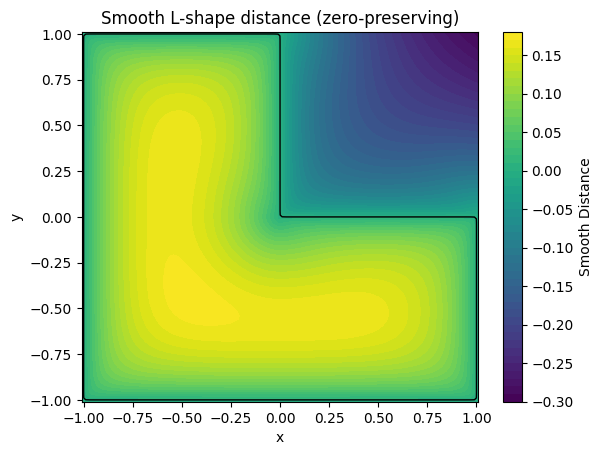

Domain transform: [0,1]² → [-1,1]×[-1,1]
Laplacian scale factor: 4
Classification...
  Inner B-splines: 16875
  Outer B-splines: 604
  Inner element arrays: 16279
Building extension matrix...
  Extension matrix: 16875 x 604, nnz = 1842
Assembling collocation matrix...
Solving linear system...
  System dimension: 16875
  Condition number: N/A (system too large)
Evaluating solution...

Results:
  Relative max error: 2.082080e-03
  Relative L2 error:  4.717346e-04
  Mean absolute error: 1.762358e-04
  Absolute L-inf error: 2.081167e-03
  H1 semi-norm error: 4.742719e-02
  H1 error:           4.742954e-02
  Condition number:   N/A
  System dimension:   16875

Timing:
  Classification/Assembly: 0.121s
  Extension:               0.036s
  Solution:                27.596s
  Total:                   27.752s


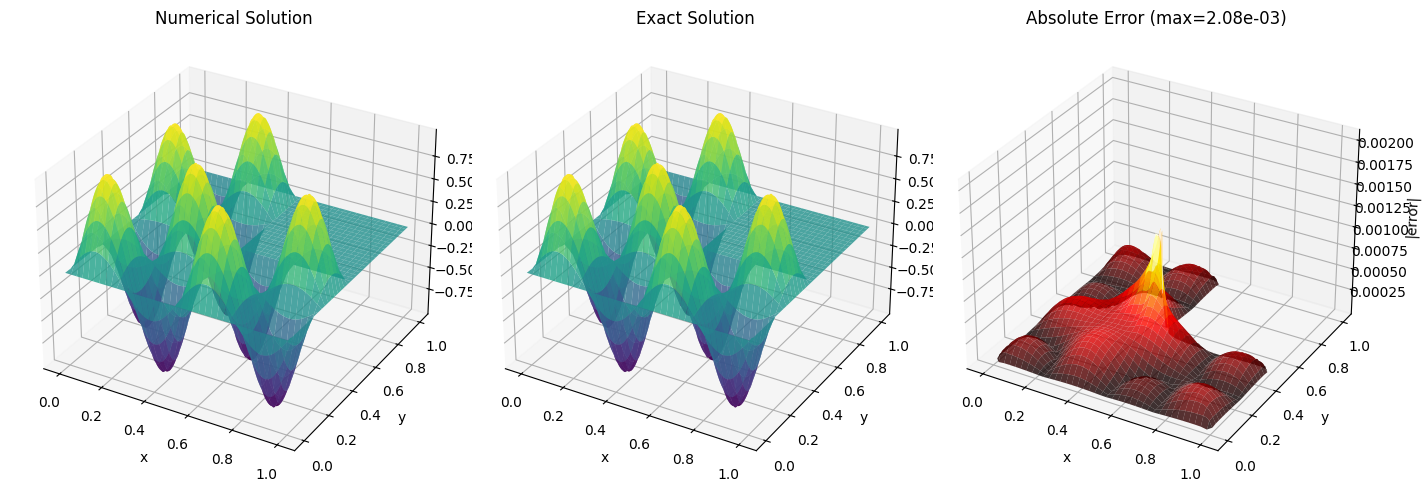

In [ ]:
importlib.reload(cWEB)
importlib.reload(FEM)
importlib.reload(Geomertry)
from network_defs import load_test_model

# Physical domain where all functions (weight, load, solution) are defined
DOMAIN = {"x1": -1, "x2": 1, "y1": -1, "y2": 1}

# Case 1: u = x*(x²+y²-1) has u=0 on unit circle (homogeneous Dirichlet BC)
function_case = 1
cWEB.FUNCTION_CASE = function_case

verbose = True
n = 2
H = 150

if verbose:
    print("=" * 60)
    print(f"WEB-Spline Collocation: degree={n}, H={H}, domain={DOMAIN}, case={function_case}")
    print("=" * 60)

# Weight function - using analytical circle distance in [-1,1]² domain
#model = Geomertry.AnaliticalDistanceCircle()
#model  = Geomertry.AnaliticalDistanceLshape()
#model = load_test_model("SIREN_L_3_0", "SIREN", params={"architecture": [2, 256, 256, 256, 1], "w_0": 80, "w_hidden": 120.0})
model = Geomertry.AnaliticalDistanceLshape_RFunction()
wfct = cWEB.NeuralWeightFunction(model=model, domain=DOMAIN, transform="tanh")
model.create_contour_plot(100)
# Create domain transformer for exact solution comparison
transformer = cWEB.create_domain_transformer(DOMAIN)

# Precompute collocation data
CD = cWEB.compute_collocation_data(n, J_MAX=16)

# Solve - now with domain parameter, f is automatically transformed and scaled!
Uxy, xB, yB, con, dim_sys, rtimes = cWEB.collocation_2d(
    n, H, wfct, 
    f=cWEB.load_function,  # Pass original function - domain transform handled internally
    CD=CD, 
    verbose=verbose,
    domain=DOMAIN  # NEW: domain parameter handles coordinate transform + Laplacian scaling
)

if Uxy is None:
    print("Solver failed!")
    raise RuntimeError("Collocation solver failed.")

# Compute exact solution at grid points using transformer
w_grid, _, _, _, _ = wfct(xB, yB)
mask = w_grid > 0

# Use transformer to wrap exact solution (transforms grid -> physical coords)
u_exact_transformed = transformer.wrap_function(cWEB.solution_function)
du_dx_transformed = transformer.wrap_derivative_x(cWEB.solution_function_derivative_x)
du_dy_transformed = transformer.wrap_derivative_y(cWEB.solution_function_derivative_y)

uxy_exact = np.zeros_like(Uxy)
uxy_exact[mask] = u_exact_transformed(xB[mask], yB[mask])

# Compute L2 and Linf errors
error = Uxy[mask] - uxy_exact[mask]
exact_vals = uxy_exact[mask]

max_exact = np.max(np.abs(exact_vals)) if np.any(exact_vals != 0) else 1.0
l2_exact = np.sqrt(np.sum(exact_vals ** 2)) if np.any(exact_vals != 0) else 1.0

ErrMax = np.max(np.abs(error)) / max_exact
ErrL2 = np.sqrt(np.sum(error ** 2)) / l2_exact
Err_MAE = np.mean(np.abs(error))
Err_L_inf = np.max(np.abs(error))

# Compute H1 semi-norm error
h = 1.0 / H
dU_dx_num, dU_dy_num = cWEB.compute_numerical_gradient(Uxy, h)

dU_dx_ex = np.zeros_like(Uxy)
dU_dy_ex = np.zeros_like(Uxy)
dU_dx_ex[mask] = du_dx_transformed(xB[mask], yB[mask])
dU_dy_ex[mask] = du_dy_transformed(xB[mask], yB[mask])

grad_error_x = dU_dx_num[mask] - dU_dx_ex[mask]
grad_error_y = dU_dy_num[mask] - dU_dy_ex[mask]
grad_exact_norm = np.sqrt(np.sum(dU_dx_ex[mask] ** 2 + dU_dy_ex[mask] ** 2))

if grad_exact_norm > 0:
    H1_semi = np.sqrt(np.sum(grad_error_x ** 2 + grad_error_y ** 2)) / grad_exact_norm
else:
    H1_semi = np.nan

H1_error = np.sqrt(ErrL2 ** 2 + H1_semi ** 2) if not np.isnan(H1_semi) else np.nan

if verbose:
    print("\n" + "=" * 40)
    print("Results:")
    print("=" * 40)
    print(f"  Relative max error: {ErrMax:.6e}")
    print(f"  Relative L2 error:  {ErrL2:.6e}")
    print(f"  Mean absolute error: {Err_MAE:.6e}")
    print(f"  Absolute L-inf error: {Err_L_inf:.6e}")
    print(f"  H1 semi-norm error: {H1_semi:.6e}" if not np.isnan(H1_semi) else "  H1 semi-norm error: N/A")
    print(f"  H1 error:           {H1_error:.6e}" if not np.isnan(H1_error) else "  H1 error:           N/A")
    print(f"  Condition number:   {con:.2e}" if not np.isnan(con) else "  Condition number:   N/A")
    print(f"  System dimension:   {dim_sys}")
    print(f"\nTiming:")
    print(f"  Classification/Assembly: {rtimes['sys']:.3f}s")
    print(f"  Extension:               {rtimes['ext']:.3f}s")
    print(f"  Solution:                {rtimes['sol']:.3f}s")
    print(f"  Total:                   {rtimes['total']:.3f}s")

result = {
    'Uxy': Uxy, 'xB': xB, 'yB': yB, 'uxy_exact': uxy_exact,
    'ErrMax': ErrMax, 'ErrL2': ErrL2, 'MAE': Err_MAE,
    'H1_semi': H1_semi, 'H1_error': H1_error,
    'condition': con, 'dim': dim_sys, 'rtimes': rtimes,
    'wfct': wfct, 'function_case': function_case
}
cWEB.visualize_solution(result)